In [2]:
import platform

def definePathWithOS():
    current_os = platform.system()
    if current_os == 'Windows':
        return ".\\dataset\\sum_meta\\",  ".\\dataset\\IAM-lines\\"
    else:
        return "./dataset/sum_meta",  "./dataset/IAM-lines/"

file_path, dataset_path = definePathWithOS()
print(file_path, dataset_path)

.\dataset\sum_meta\ .\dataset\IAM-lines\


In [3]:
import os
from sklearn.model_selection import train_test_split

def preprocess_dataset(file_path, dataset_path):
    dataset, vocab, max_len = [], set(), 0
    # We will use IAM lines dataset
    sentences = open(os.path.join(file_path, "lines.txt"), "r").readlines()
    for line in sentences:
        if line.startswith("#"):
            continue

        line_split = line.split(" ")
        if line_split[1] == "err":
            continue

        folder1 = line_split[0][:3]
        folder2 = line_split[0][:8]
        file_name = line_split[0] + ".png"
        label = line_split[-1].rstrip('\n')

        label = label.replace('|', ' ')
        rel_path = os.path.join(dataset_path, folder1, folder2, file_name)

        if not os.path.exists(rel_path):
            continue

        dataset.append([rel_path, label])
        vocab.update(list(label))
        max_len = max(max_len, len(label))

    # Splitting the dataset into training and validation sets
    train_values, test_values = train_test_split(
        dataset, test_size=0.2, random_state=42)

    return train_values, test_values, max_len, vocab

train_values, test_values, max_len, vocab = preprocess_dataset(
        file_path, dataset_path)
print(train_values, test_values)

[['.\\dataset\\IAM-lines\\a01\\a01-049u\\a01-049u-04.png', 'Communist affiliations . The Senate Banking'], ['.\\dataset\\IAM-lines\\g06\\g06-011m\\g06-011m-01.png', 'Naples . He told Cloncurry that he enjoyed it as'], ['.\\dataset\\IAM-lines\\c03\\c03-096e\\c03-096e-01.png', 'explicably from appreciable motives . The'], ['.\\dataset\\IAM-lines\\g06\\g06-050c\\g06-050c-05.png', 'with a gentle and charming character , even-tempered'], ['.\\dataset\\IAM-lines\\a01\\a01-043u\\a01-043u-00.png', 'Informal talks at Lancaster House will'], ['.\\dataset\\IAM-lines\\g07\\g07-022a\\g07-022a-05.png', 'is a pleasing , fine looking young man &'], ['.\\dataset\\IAM-lines\\g06\\g06-042a\\g06-042a-02.png', 'the 6tic douloureux . As early as 1830 , when'], ['.\\dataset\\IAM-lines\\g06\\g06-011b\\g06-011b-06.png', 'is going out fast ... . What a gay , lively'], ['.\\dataset\\IAM-lines\\g06\\g06-047c\\g06-047c-03.png', "a human being ' , had an increasing number of"], ['.\\dataset\\IAM-lines\\g06\\g06-037

In [4]:
# IAM dataset implementation is based on Hugging Face documentation
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df[idx][0]
        text = self.df[idx][1]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values, "labels": torch.tensor(labels)}
        return encoding

# We use a pretrained model from Hugging Face

from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(train_values, processor)
test_dataset = IAMDataset(test_values, processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(test_dataset))

Number of training examples: 2022
Number of validation examples: 506


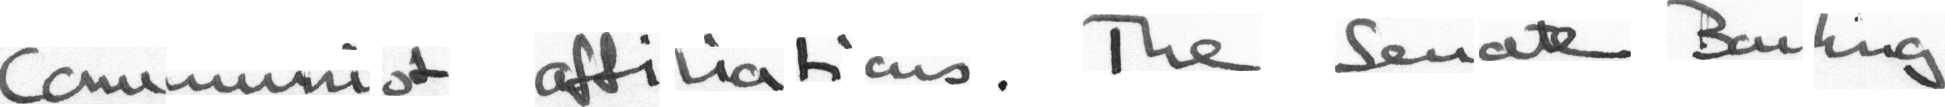

In [6]:
# Example showcase

image = Image.open(train_values[0][0]).convert("RGB")
image

In [7]:
encoding = train_dataset[0]
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Communist affiliations. The Senate Banking


In [8]:
# Random test

from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


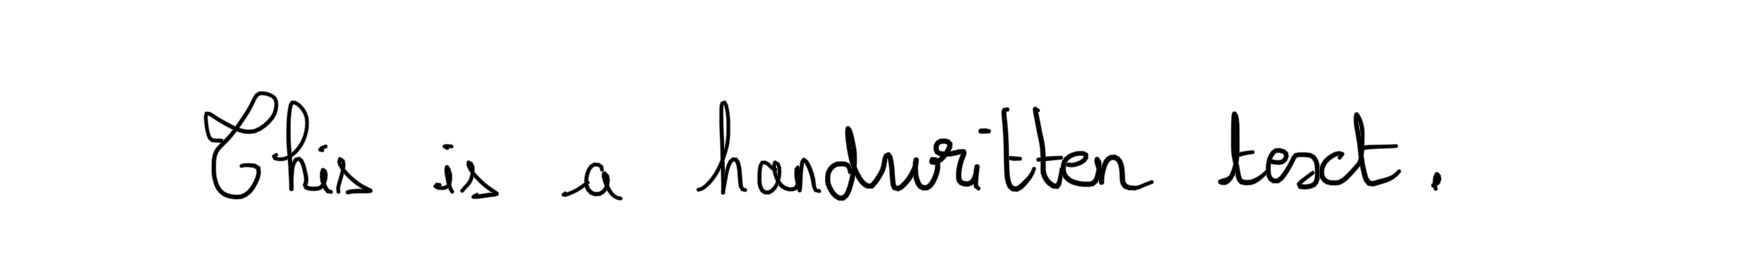

In [9]:
image = Image.open('test.jpg').convert("RGB")
image

In [10]:
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

c:\Users\Huu-Tu\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


This is a handwritten boat.


In [11]:
# # TODO:
# - Train model
# - Load model trained on example
# - Print loss

In [1]:
#je m'insere
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from torch.utils.data import DataLoader
import torch

# Load the pre-trained Vision Encoder Decoder Model
toBeTrainedModel = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Define a device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
toBeTrainedModel.to(device)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Define the optimizer
optimizer = AdamW(toBeTrainedModel.parameters(), lr=5e-5)

# Training parameters
num_epochs = 5

toBeTrainedModel.config.decoder_start_token_id = processor.tokenizer.cls_token_id

# Set the pad_token_id
toBeTrainedModel.config.pad_token_id = processor.tokenizer.pad_token_id

# Training loop
toBeTrainedModel.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        # Move batch to device
        pixel_values = batch['pixel_values'].squeeze().to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = toBeTrainedModel(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

toBeTrainedModel.save_pretrained("/path/to/save/trainedModel")


c:\Users\Huu-Tu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'VisionEncoderDecoderModel' is not defined